In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

# Step 1: Download Images

In [5]:
from fastcore.all import *
import time

def search_images(term, max_images=30):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [6]:
urls = search_images('goku', max_images=1)
urls[0]

'https://www.pngmart.com/files/3/Dragon-Ball-Goku-PNG-Free-Download.png'

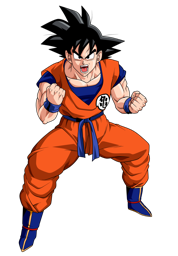

In [7]:
from fastdownload import download_url
from fastai.vision.all import *

dest = 'goku.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

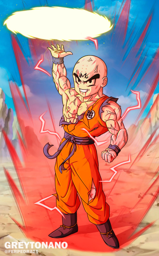

In [8]:
download_url(
    search_images('krillin', max_images=1)[0], 
    'krillin.jpg', 
    show_progress=False
)
Image.open('krillin.jpg').to_thumb(256,256)

In [9]:
from time import sleep

searches = 'goku', 'krillin'
path = Path('goku_or_krillin')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(o))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Step 2: Train Model

In [10]:
# Remove any broken images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

`DataLoaders` - an object that contains our images (both training and validation). The DataLoader stores the images in "batches."

`DataBlock` - used to create DataLoader, and perfrom preprocessing steps. 

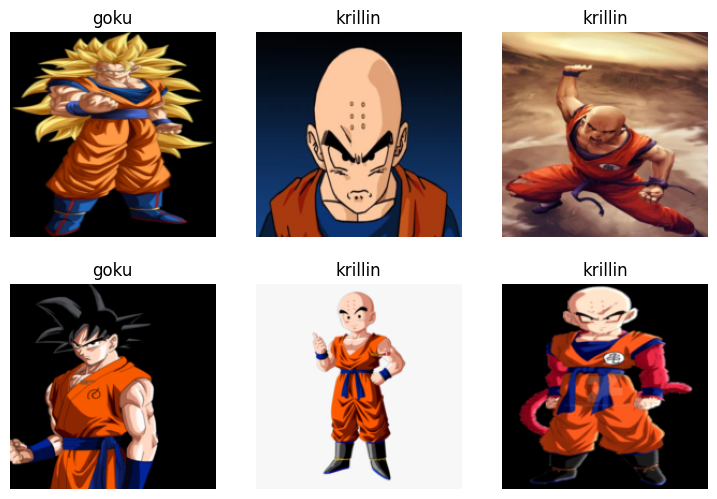

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Below, we will use resnet18, a pretrained image model. We can build on top of ResNet18, fine-tuning it to adapt to our specific needs.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.092542,1.188677,0.700000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.777954,0.865942,0.500000,00:00
1,0.744440,0.542058,0.200000,00:00
2,0.510090,0.467285,0.200000,00:00


# Step 3: Using Our Model

In [16]:
is_goku,_,probs = learn.predict(PILImage.create('goku.jpg'))
print(f"This is: {is_goku}.")
print(f"Proability this is {is_goku}: {probs[0]:.4f}")

This is: goku.
Proability this is goku: 0.7812


In [17]:
is_krillin,_,probs = learn.predict(PILImage.create('krillin.jpg'))
print(f"This is: {is_krillin}.")
print(f"Proability this is {is_krillin}: {probs[0]:.4f}")

This is: goku.
Proability this is goku: 0.6592


So the model isn't always correct. Perhaps we could specify the version of Goku and Krillin we want to use. This could be done when creating the dataset/downloading the images. We could specify "dragon ball." 